# **Recency: <br>Age Distribution of Documents in an Enterprise Corpus**


* [Introduction](#Introduction)
* [Solr recip date boosting function](#Recip)
* [ES: Document Age Distribution](#ESdistribution)
* [WS: Website Age Distribution](#WSdistribution)
* [Comparion/Discussion](#Discussion)
* [References](#References)

# **Introduction**  <a class="anchor"  id="Introduction"></a>
For search queries where current information is essential, prioritizing recent documents enhances the usefulness of search results.

In the Web Search (WS) context, the timeliness of information is often critical to user satisfaction. Examples of time-critical documents for rapidly evolving topics include breaking news, financial data, or event announcements, etc.    In the context of Enterprise Search (ES), users generally do not require or expect this level of immediacy.  Nonetheless, a document that was updated this year is likely to be more useful for users than one (with the same similarity matching score) that was updated thirty years ago.  

Two plots are produced: -
1.  The first is for ES and plots document count versus *document* age, covering a period of 30 years.
2.  The second plot is for WS and plots website count versus *website* age (also covering 30 years)

# **Solr 'recip' date boosting function** <a class="anchor" id="Recip"></a>


Boosting by date field in solr can achieved using the following function in the command line: -

<div>
    
    !boost b=recip(ms(NOW,pubdate),3.16e-11,1,1

where *pubdate*  is the document create or modification timestamp.
</div>



    

    Recip is a highly tunable function and this investigation will determine if the same parameters can be used for ES and WS.

    
    
There are approximately 3.16e10 milliseconds in a year, so one can scale dates to fractions of a year with the inverse, or 3.16e-11. Thus the function recip(ms(NOW,pubdate),3.16e-11,1,1) will yield values near 1 for very recent documents, 1/2 for documents a year old, 1/3 for documents two years old, etc. nd. Breaking up the **recip(x,m,a,b)** function we get the following parts: -

    x  = NOW minus pubdate
    m = 3.16e-11 

m is a constant that defines a timescale which is used to apply a boostThere are approximately 3.16e10 milliseconds in a year, so one can scale dates to fractions of a year with the inverse, or 3.16e-11. Thus the function recip(ms(NOW,mydatefield),3.16e-11,1,1) will yield values near 1 for very recent documents, 1/2 for documents a year old, 1/3 for documents two years old, etc.  . It is relative to what we would consider an 'old' document and is the inverse age (hence the -11) of the document in milliseconds. This is currently set to be 3.16e-11, which means that the cut off point for our article boost will be roughly 1 year. We can work out different amounts by using the formula 1/(milliseonds), so if you want the value to be 6 months then it would be 6.3411541e-11, for 3 months this would be 1.2683917e-1  
    
    a = 1
    b = 1

These final two values are constants that effect the curve of the function. Lower values mean that the line drops off quickly, a value of 1 for each will mean very shallow line that doesn't give much boost and goes heads downwards slowly.


# **ES: Document age distrubution** <a class="anchor" id="ESdistribution"></a>
A search demand curve is a graphical representation that illustrates the volume of search queries related to a keyword or set of query terms over time.
Enterprise Search (ES) can be simply defined as finding the information needed from within an 

Apache Solr has a built-in `recip' time decay function, wherein the ranking score of a document decreases as it ages. This ensures newer documents are emphasized, while older documents remain accessible based on query-document term relevance matching.  For this function to work, the publication timestamp of documents must be recorded and indexed.  The Figure below plots the number of documents versus document age in the University's ES index.


In [1]:
# Python 3 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt


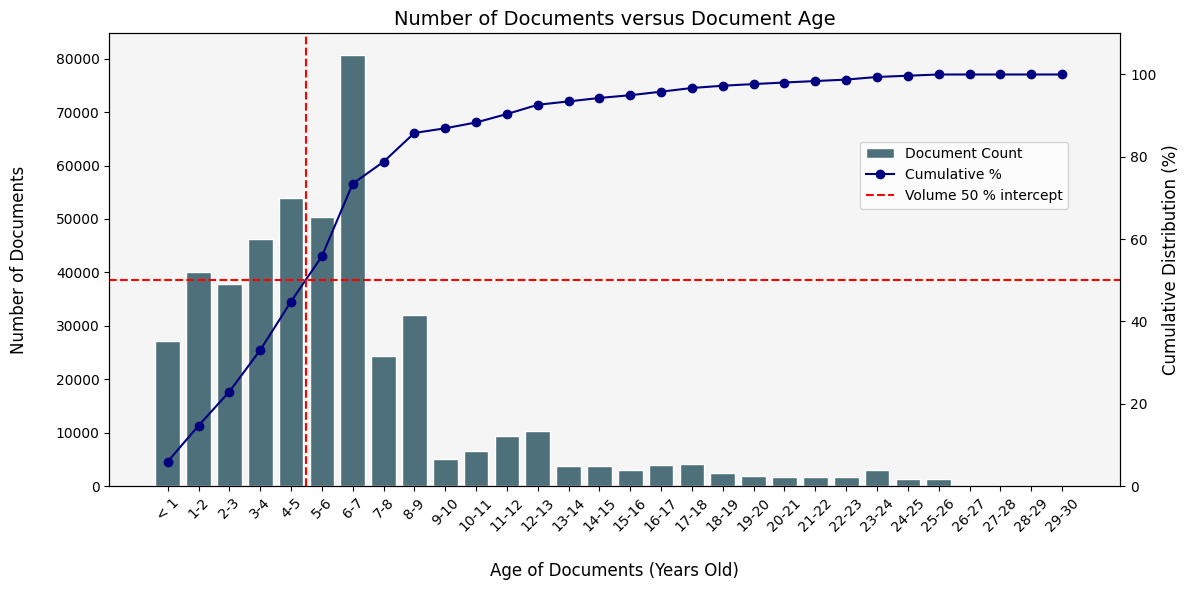

In [2]:
# ES Data for years and the number of documents 
# This data was extracted from a University ES  solr index

years = [  # six rows, five columns, gives 30 years
    "< 1", "1-2", "2-3", "3-4", "4-5", "5-6",
    "6-7", "7-8", "8-9", "9-10", "10-11", "11-12",
    "12-13", "13-14", "14-15", "15-16", "16-17", "17-18",
    "18-19", "19-20", "20-21", "21-22", "22-23", "23-24",
    "24-25", "25-26", "26-27", "27-28", "28-29", "29-30"
]  

num_documents = [
27145,39985,37880,46177,54001,50315,
80708,24434,32075,5153,6504,9357,
10299,3737,3845,3062,3909,4118,
2514,1851,1728,1629,1603,2938,
1381,1365,0,1,1,0
]




# Calculate cumulative distribution
cumulative_distribution = np.cumsum(num_documents)

# Normalize for percentage distribution
cumulative_distribution_percentage = (cumulative_distribution / cumulative_distribution[-1]) * 100

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for document count
color1 = '#4E707A'
ax1.bar(years, num_documents, color=color1, edgecolor='white', label='Document Count')
ax1.set_xlabel('Age of Documents (Years Old)', fontsize=12, labelpad=20)
ax1.set_ylabel('Number of Documents', fontsize=12, labelpad=20)
ax1.tick_params(axis='y', labelsize=10)
ax1.set_title('Number of Documents versus Document Age', fontsize=14)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.set_facecolor('whitesmoke')


# Cumulative distribution line plot
color2 = '#919191'
ax2 = ax1.twinx()
ax2.plot(years, cumulative_distribution_percentage, color='navy', marker='o', label='Cumulative %')
ax2.set_ylabel('Cumulative Distribution (%)', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)
ax2.set_ylim(0, 110)


# Find the n% intercept volume and year
n_percent_volume = 50
intercept_index_n = np.argmax(cumulative_distribution_percentage >= n_percent_volume)
#intercept_year_n = years[intercept_index_n]
intercept_year_n = 4.5   # correction for bin size differential

intercept_volume_n = cumulative_distribution[intercept_index_n]

# Add the n% intercept line
ax2.axhline(y=n_percent_volume, color='red', linestyle='--', label=f"Volume {n_percent_volume} % intercept")
ax2.axvline(x=intercept_year_n, color='red', linestyle='--')
ax1.annotate(f"",
             xy=(intercept_year_n, n_percent_volume), xycoords='data',
             #xytext=(intercept_year_n, n_percent_volume + 10),
             arrowprops=dict(arrowstyle="->", color='black'),
             fontsize=10, color='black')


# Add legends for clarity
fig.legend(loc='center right', bbox_to_anchor=(0.9, 0.7), fontsize=10)

# Tight layout and show the plot
plt.tight_layout()

plt.savefig('Fig-Document-Recency-Inventory.png', bbox_inches='tight')  
plt.show()


# **WS: Website age distrubution** <a class="anchor" id="WSdistribution"></a>
A search demand curve is a graphical representation that illustrates the volume of search queries related to a keyword or set of query terms over time.
Enterprise Search (ES) can be simply defined as finding the information needed from within an 


Figure shows that about 80% of all Websites on the internet were created over the past five years.   This is in contrast to the University's index, which shows that about % were created in the past five years.

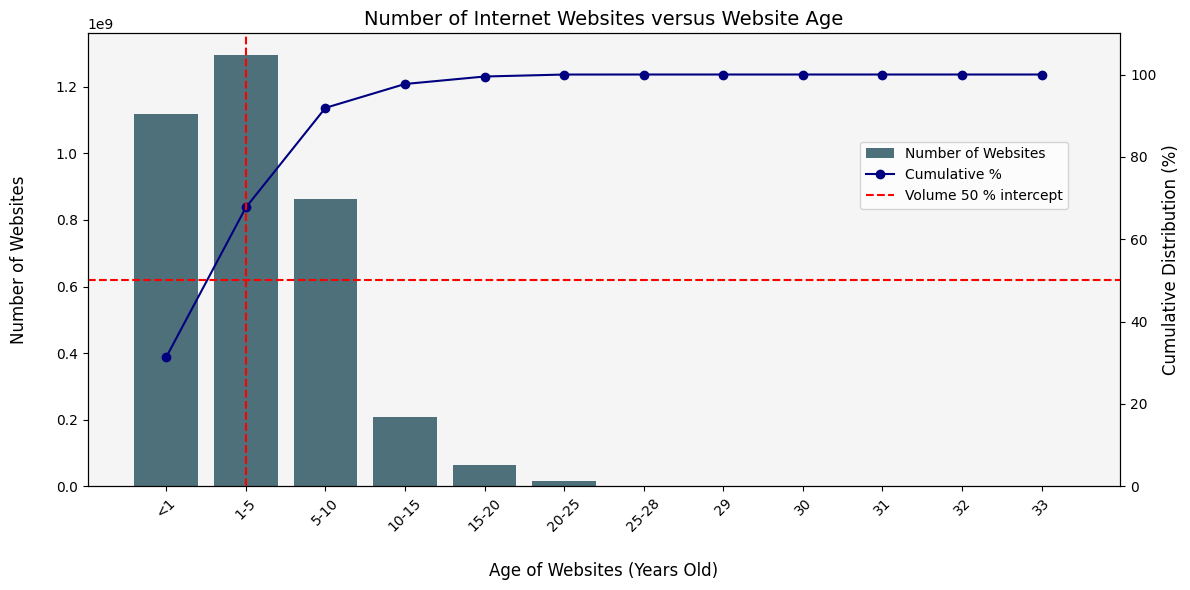

In [3]:
# WS Data for years and the number of websites
# This data is from https://explodingtopics.com/blog/how-many-websites-on-the-internet


years = [  # covers 33 years, bin scales are not uniform, but it doesn't matter to shape of plot.
    "<1", "1-5", "5-10", "10-15", "15-20", 
    "20-25", "25-28", "29", 
    "30", "31", "32", "33"
]




#num_websites = [
#    1, 10, 130, 2738, 23500, 
#    257601, 17087182, 64780617, 206956723, 
#    863105652, 1295973827, 1119023272
#]

num_websites = [
   1119023272, 1295973827, 863105652, 206956723, 64780617, 
    17087182, 257601, 23500, 
    2738, 130, 10, 1
]


# Calculate cumulative distribution
cumulative_distribution = np.cumsum(num_websites)

# Normalize for percentage distribution
cumulative_distribution_percentage = (cumulative_distribution / cumulative_distribution[-1]) * 100


# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for the number of websites
colour1 = '#4E707A'
ax1.bar(years, num_websites, color=colour1, label='Number of Websites')
ax1.set_xlabel('Age of Websites (Years Old)', fontsize=12, labelpad=20)
ax1.set_ylabel('Number of Websites', fontsize=12, labelpad=20)
ax1.tick_params(axis='y', labelsize=10)
ax1.set_title('Number of Internet Websites versus Website Age', fontsize=14)
ax1.tick_params(axis='x', labelsize=10, labelrotation=45)
ax1.invert_xaxis()  # Reverse the order of the x-axis
ax1.set_facecolor('whitesmoke')



# Cumulative distribution line plot
color2 = '#919191'
ax2 = ax1.twinx()
ax2.plot(years, cumulative_distribution_percentage, color='navy', marker='o', label='Cumulative %')
ax2.set_ylabel('Cumulative Distribution (%)', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)
ax2.set_ylim(0, 110)


# Find the n% intercept volume and year
n_percent_volume = 50
intercept_index_n = np.argmax(cumulative_distribution_percentage >= n_percent_volume)
intercept_year_n = years[intercept_index_n]
intercept_volume_n = cumulative_distribution[intercept_index_n]


# Add the n% intercept line
ax2.axhline(y=n_percent_volume, color='red', linestyle='--', label=f"Volume {n_percent_volume} % intercept")
ax2.axvline(x=intercept_year_n, color='red', linestyle='--')
ax1.annotate(f"",
             xy=(intercept_year_n, n_percent_volume), xycoords='data',
             #xytext=(intercept_year_n, n_percent_volume + 10),
             arrowprops=dict(arrowstyle="->", color='black'),
             fontsize=10, color='black')

# Add legends for clarity
fig.legend(loc='center right', bbox_to_anchor=(0.9, 0.7), fontsize=10)

plt.gca().invert_xaxis()  # Reverse x-axis

# Tight layout and show the plot
#plt.xlim(3,9)   # cut off x-axis to 30 years, which is what we have for the ES plot.
plt.tight_layout()
plt.savefig('Fig-Website-Recency-Inventory.png', bbox_inches='tight')  

plt.show()



 # **Comparison/Discussion** <a class="anchor"  id="Discussion"></a>

**Similarity**
In the ES document distribution plot, we see that about 50\% of all documents in the corpus (solr index) are have been created or modified in the last five years. The volume intercept is represented by the red dashed line. Similarly, the WS website distribution plot, 50\% of all websites have been created within the past five years.

**Difference**
The cumulative distribution curve takes a slighly different shape in both plots.  The cumulative distrubtion is represented by the navy line in the plots.  For ES, we see that the document creation (or modifcation) trend increases and decreases over time.  This contrasts with the WS plot, which shows an (almost) ever-increasing website growth rate.

**Discussion**
In the ES plot, we see a spike in documents that were created (or modified) during the 6-7 year old time period.  This is probably caused by a refresh of the organisation's Web Content Management System (WCMS) or the addition of the corporate directory to the ES index at the approximately the same time.   For the WS plot, the rate website growth was steep until about 2020[1], when there was a "shift to mobile apps, the consolidation of web services, and the change in how websites are tracked today"[2].

**Implications for Ranking**
Since the historical time-frame of publication dates is similar for both WS and our ES index (30 years), and since the cumulative distribution curve follows approximately the same shape, it is assumed that the same parameter values for m, a and b can be used.


 # **References** <a class="anchor"  id="References"></a>

[1] https://digital.csic.es/bitstream/10261/366936/1/How_old_is_web.pdf

[2] 
https://explodingtopics.com/blog/how-many-websites-on-the-internetdown